In [10]:
import os
from dotenv import load_dotenv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.metrics.pairwise import cosine_similarity

load_dotenv()

base_path = os.getenv("BASE_LOCAL_DIR_PATH")

df_data_org = pd.read_json(f"{base_path}project_notebook/ALS/data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


## Preprocessing dataset

#### make score data 
> count of user's select /count of provided events

제공 대비 선택 확률을 기반으로 user별로 item에 대한 `선택 확률`로서 추정.

#### split segments of users
1. n개 이상 user에게 동시에 제공된 이력이 있는 item 내역 추출
2. 각 user별로 해당 item에 대한 경험 정도를 합집합/교집합으로 나눠 유사도를 측정
    - 선택 집합 유사도 측정 방법: *cosine similarity*
    - 선택 아이템의 선호에 대한 유사도 측정 방법: *euclidean distance*
3. *cosine similarity & euclidean distance* 유사도 기반 군집화 알고리즘을 통해 segments 분리
    - *상세 내용 미정*

## Make score data

In [59]:
df_data = df_data_org.copy()

def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    res['reject_cnt'] = res['apply_cnt'] - res['join_cnt']
    res['ratio'] = res['join_cnt'] / res['apply_cnt']
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)
df_grouped

,user_id,item_id,apply_cnt,join_cnt,reject_cnt,ratio
0,0,0,3.0,0.0,3.0,0.000
1,0,1,3.0,0.0,3.0,0.000
2,0,2,2.0,1.0,1.0,0.500
3,0,3,8.0,1.0,7.0,0.125
4,0,7,5.0,1.0,4.0,0.200
...,...,...,...,...,...,...
28497,69,1930,1.0,0.0,1.0,0.000
28498,69,1931,3.0,0.0,3.0,0.000
28499,69,1932,1.0,0.0,1.0,0.000
28500,69,1935,2.0,0.0,2.0,0.000


## Make sample data of items

In [20]:
df_items = df_data[['item_id', 'user_id']].groupby(['item_id']).nunique().reset_index()
df_items

,item_id,user_id
0,0,3
1,1,2
2,2,1
3,3,5
4,4,20
...,...,...
1949,1949,2
1950,1950,1
1951,1951,3
1952,1952,5


<AxesSubplot: xlabel='user_id', ylabel='Density'>

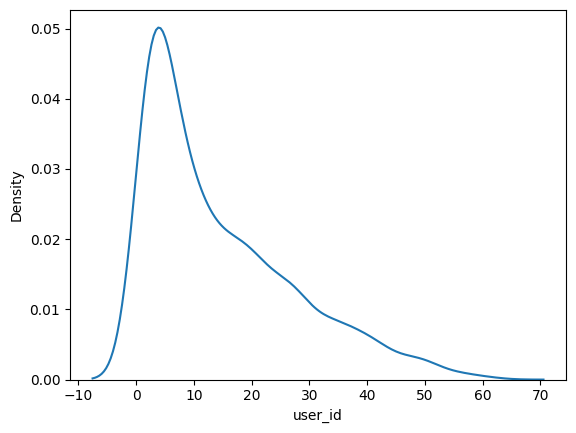

In [30]:
sns.kdeplot(df_items['user_id'])

In [33]:
# filtering items where provided count >10
sample_items = list(df_items.loc[df_items['user_id']>10, "item_id"])

## Apply cosine similarity & euclidean distance

### cosine similarity

In [35]:
def make_group(value):
    res = dict()
    data = value.to_dict(orient='records')
    for row in data:
        res[row['item_id']] = row['ratio']
    return res

cos_records = df_grouped.groupby('user_id').apply(make_group)
cos_records = cos_records.to_dict()

In [39]:
def get_cosine_similarity(target:dict, check:dict, mode:str ="full"):
    if mode == "full":
        full_items = set(list(target.keys()) + list(check.keys()))
    elif mode == "intersection":
        full_items = set(list(target.keys())).intersection(list(check.keys()))
    list_target = list()
    list_check = list()
    for idx in full_items:
        if target.get(idx) == None:
            list_target.append(0)
        else:
            if target.get(idx) >=0.5:
                list_target.append(1)
            else:
                list_target.append(-1)
        
        if check.get(idx) == None:
            list_check.append(0)
        else:
            if check.get(idx) >=0.5:
                list_check.append(1)
            else:
                list_check.append(-1)

    return np.dot(list_target,list_check)/( np.linalg.norm(list_target)*np.linalg.norm(list_check))


#### full set

<AxesSubplot: >

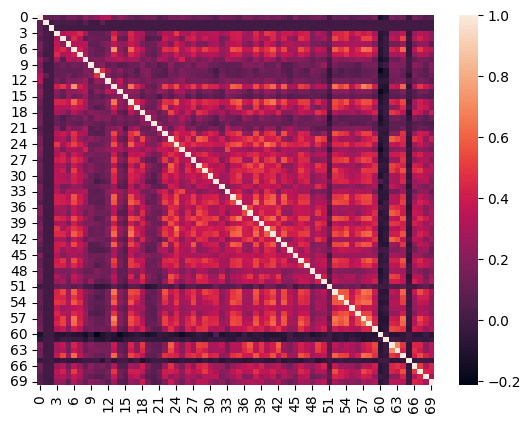

In [43]:
res_data = dict()
for target_idx, target_user in cos_records.items():
    check_data =dict()
    for check_idx, check_user in cos_records.items():
        check_data[check_idx] = get_cosine_similarity(target_user, check_user)
    res_data[target_idx] = check_data

cos_full = pd.DataFrame(res_data)
sns.heatmap(cos_full)

#### intersection set

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_3777/3710704165.py:25: RuntimeWarning: invalid value encountered in scalar divide
  return np.dot(list_target,list_check)/( np.linalg.norm(list_target)*np.linalg.norm(list_check))


<AxesSubplot: >

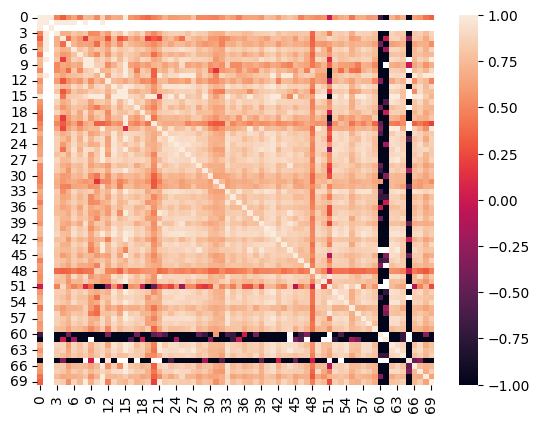

In [44]:
res_data = dict()
for target_idx, target_user in cos_records.items():
    check_data =dict()
    for check_idx, check_user in cos_records.items():
        check_data[check_idx] = get_cosine_similarity(target_user, check_user, mode='intersection')
    res_data[target_idx] = check_data

cos_inter = pd.DataFrame(res_data)
sns.heatmap(cos_inter)

In [47]:
cos_full.iloc[0].sort_values(ascending=False)

0     1.000000
12    0.338317
11    0.318158
8     0.239594
14    0.222395
        ...   
68    0.045302
51    0.000000
65   -0.038633
61   -0.054636
60   -0.122169
Name: 0, Length: 70, dtype: float64

In [48]:
cos_inter.iloc[0].sort_values(ascending=False)

15    1.000000
0     1.000000
2     1.000000
1     1.000000
11    0.851852
        ...   
4     0.325301
51    0.000000
60   -0.666667
61   -1.000000
65   -1.000000
Name: 0, Length: 70, dtype: float64

### euclidean distance

#### full set

In [83]:
def make_group(data:pd.DataFrame):
    # data.index = data['user_id']
    data['score'] = data['join_cnt'] - data['reject_cnt']
    return data.loc[:, ['item_id', 'score']]


test = df_grouped.groupby(by=['user_id'], group_keys=True).apply(make_group)

In [72]:
df_grouped

,user_id,item_id,apply_cnt,join_cnt,reject_cnt,ratio
0,0,0,3.0,0.0,3.0,0.000
1,0,1,3.0,0.0,3.0,0.000
2,0,2,2.0,1.0,1.0,0.500
3,0,3,8.0,1.0,7.0,0.125
4,0,7,5.0,1.0,4.0,0.200
...,...,...,...,...,...,...
28497,69,1930,1.0,0.0,1.0,0.000
28498,69,1931,3.0,0.0,3.0,0.000
28499,69,1932,1.0,0.0,1.0,0.000
28500,69,1935,2.0,0.0,2.0,0.000


In [50]:
cos_records[0]

{0: 0.0,
 1: 0.0,
 2: 0.5,
 3: 0.125,
 7: 0.2,
 8: 0.0,
 10: 0.0,
 11: 0.75,
 12: 0.0,
 13: 0.5,
 15: 0.0,
 16: 0.2857142857142857,
 18: 0.0,
 19: 0.0,
 20: 0.25,
 23: 0.0,
 30: 0.0,
 33: 0.0,
 34: 0.5,
 35: 0.1111111111111111,
 36: 0.0,
 37: 1.0,
 38: 0.0,
 40: 0.0,
 41: 0.3333333333333333,
 42: 0.0,
 43: 0.6666666666666666,
 44: 0.0,
 53: 0.0,
 55: 0.0,
 56: 0.3333333333333333,
 57: 0.0,
 58: 0.0,
 59: 0.0,
 60: 1.0,
 61: 0.5714285714285714,
 62: 0.0,
 63: 0.0,
 64: 0.0,
 66: 0.0,
 68: 0.0,
 70: 0.0,
 71: 0.0,
 73: 0.0,
 74: 0.0,
 75: 0.0,
 77: 0.6666666666666666,
 83: 0.0,
 84: 0.0,
 93: 0.0,
 94: 0.0,
 96: 0.0,
 103: 0.0,
 104: 0.0,
 113: 0.0,
 117: 0.0,
 118: 0.0,
 125: 0.5,
 149: 0.0,
 172: 0.5,
 175: 0.0,
 181: 0.5,
 183: 1.0,
 188: 0.3333333333333333,
 193: 0.0,
 203: 0.0,
 208: 0.0,
 209: 0.0,
 219: 0.0,
 220: 0.0,
 228: 0.0,
 229: 0.0,
 233: 0.0,
 234: 0.2,
 238: 0.0,
 241: 0.3333333333333333,
 243: 0.0,
 245: 0.0,
 246: 0.2,
 247: 0.0,
 251: 0.0,
 256: 0.0,
 257: 0.0,
 258: 

In [ ]:
def get_euclidean(target:dict, check:dict):
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    

In [56]:
np.linalg.norm(
    np.array((0,1,2)) - np.array((1, 2, 3))
)

1.7320508075688772

In [57]:
def get_cosine_similarity(target:dict, check:dict, mode:str ="full"):
    if mode == "full":
        full_items = set(list(target.keys()) + list(check.keys()))
    elif mode == "intersection":
        full_items = set(list(target.keys())).intersection(list(check.keys()))
    list_target = list()
    list_check = list()
    for idx in full_items:
        if target.get(idx) == None:
            list_target.append(0)
        else:
            if target.get(idx) >=0.5:
                list_target.append(1)
            else:
                list_target.append(-1)
        
        if check.get(idx) == None:
            list_check.append(0)
        else:
            if check.get(idx) >=0.5:
                list_check.append(1)
            else:
                list_check.append(-1)

    return np.dot(list_target,list_check)/( np.linalg.norm(list_target)*np.linalg.norm(list_check))


1.7320508075688772